In [1]:
!pip install datasets
!pip install torchmetrics
!pip install transformers
!pip install evaluate
!pip install accelerate -U
!pip install transformers[torch]
!pip install torcheval
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# connect to google drive for getting dataset
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [3]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torch
from torch.nn import functional as F
from torcheval.metrics import  MulticlassF1Score, MulticlassAccuracy
import matplotlib.pyplot as plt

@torch.no_grad()
def evaluate(model, data_loader, f1_metric, acc_metric):
    model.eval()
    for X, y in data_loader:
      y_hat = model.inference(X)
      f1_metric.update(y_hat.view(-1), y)
      acc_metric.update(y_hat.view(-1), y)
    f1_score = f1_metric.compute().item()
    acc_score = acc_metric.compute().item()
    f1_metric.reset()
    acc_metric.reset()
    return f1_score, acc_score

def plot_curve(train_loss_list, test_acc_list, test_f1_list):
    X = range(len(train_loss_list))
    plt.plot(train_loss_list, label="train_loss")
    plt.plot(test_acc_list, label="test_acc")
    plt.plot(test_f1_list, label="test_f1")
    plt.legend()
    plt.show()

class Trainer:
  def __init__(self, train_data, test_data, model, epoch=100, lr=0.005, batch_size = 64, optim=AdamW, device="cuda" if torch.cuda.is_available() else "cpu"):
      self.train_data = train_data
      self.test_data = test_data
      self.device = device
      self.model = model.to(self.device)
      self.optimizer = optim(self.model.parameters(), lr=lr, eps = 1e-8)
      self.epoch = epoch
      self.batch_size = batch_size
      self.lr = lr
      self.f1 =  MulticlassF1Score(num_classes=self.model.get_number_classes(), average="macro")
      self.acc = MulticlassAccuracy()

  def lm_collate_fn(self, batch, tokenize_fn):
      batch_text = [row["text"] for row in batch]
      batch_label = [row["label"] for row in batch]
      # batch tokenize input text
      tokenize_feature = tokenize_fn(batch_text)
      tokenize_feature["input_ids"] = tokenize_feature["input_ids"].long().to(self.device)
      tokenize_feature["attention_mask"] = tokenize_feature["attention_mask"].long().to(self.device)
      return tokenize_feature, torch.tensor(batch_label).long().to(self.device)

  @torch.no_grad()
  def evaluate_model(self):
      self.model.eval()
      return evaluate(self.model, self.test_dataloader, self.f1, self.acc)

  def train(self):
      self.train_dataloader = DataLoader(self.train_data, batch_size=self.batch_size, collate_fn=lambda batch: self.lm_collate_fn(batch, tokenize_fn=self.model.tokenized_input))
      self.test_dataloader = DataLoader(self.test_data, batch_size=256, collate_fn=lambda batch: self.lm_collate_fn(batch, tokenize_fn=self.model.tokenized_input))
      train_loss_list = []
      test_acc_list = []
      test_f1_list = []
      for i in range(self.epoch):
        train_loss = 0
        n_points = 0
        for X,y in self.train_dataloader:
          # print(y)
          self.model.train(True)
          loss, logits = self.model.get_loss(X,y)
          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          train_loss += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
          self.optimizer.step()
          self.optimizer.zero_grad()
          n_points += 1
        print(train_loss/n_points)
        train_loss_list.append(train_loss/n_points)
        test_f1, test_acc = self.evaluate_model()
        test_f1_list.append(test_f1)
        test_acc_list.append(test_acc)
      # plot graph
      plot_curve(train_loss_list, test_acc_list, test_f1_list)
      return self.model

In [4]:
from model.system_factory import SystemFactory
from utils.datafactory import DataFactory
import torch.nn as nn
from torch.optim import AdamW

# get dataset
data_filepath = "/content/drive/MyDrive/Colab Notebooks/combined_data.csv"
train_data, test_data = DataFactory(data_filepath).train_test_split(train_ratio=0.8, n_data=20000)

0.7099730690717697
0.5562042592763901
0.539709878206253
0.5295751613676548
0.5211409440338611
0.5143965578973293
0.5086026144921779
0.5035988418459892
0.49926562696695326
0.49538355976343157


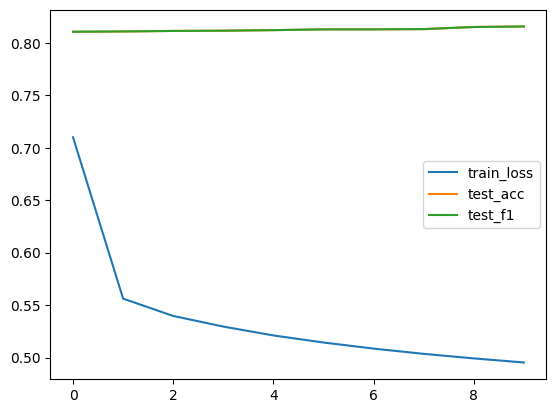

EmoFilmSystem(
  (feature_extractor): GPT2Extractor(
    (model): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
  )
  (classifier): Classifier(
    (sigmod): Sigmoid()
    (softmax): Softmax(dim=-1)
    (model): Seque

In [6]:
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:<10000>"
# os.environ["CUDA_MODULE_LOADING"] = "LAZY"
# default using gpu
torch.manual_seed(10)
trainer_config = {
    "epoch": 5,
    "lr":2e-5,
    "batch_size": 32,
    "optim": AdamW,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

system_config = {
    "extractor_config":{"pre_train_model_name":"gpt2-medium",
                        "train_extractor":False},
    "classifier_config":{"number_classes":3,
                         "hidden_units":[32]},
    "Lossfn":nn.CrossEntropyLoss,
    "max_length":128
}
# initialize system
emofilmsystem = SystemFactory.produce_system(**system_config)
# initialize trainer
trainer = Trainer(train_data=train_data, test_data=test_data, model=emofilmsystem, **trainer_config)
trainer.train()


In [ ]:
trainer.evaluate_model()